## Onboard measurement residuals

As the plan is to reduce the threshold on the maximum allowed onboard star residual that will be allowed to
contribute to the Kalman filter, we'd like to evaluate the effects of that plan, such as the increased risk of safing action due to not having enough Kalman stars.  One way to evaluate that is to estimate the number of Kalman stars that will be available with the new limit by directly applying the limit to the onboard residuals and estimating the number of stars availabe in historical data.

The onboard measurement residuals are available as a telemetered data product, but they haven't been used much in previous analysis, are not available in PCAD subformat (which means they are missing from most of 2013 and some of 2012), and one of the image residuals (residual 6 on the Z axis) appears to be available less often than the others.

Additionally, they residuals are not in slot order, but are instead in a continuously-updated tracking catalog order.  In practice this order does not seem to change much within an observation, but the possibility exists.  As such, perfect fidelity is not possible.

In [1]:
import numpy as np
from astropy.table import Table
import mica.quaternion
from Ska.quatutil import radec2eci
import agasc
from kadi import events
from Ska.engarchive import fetch
from Ska.Matplotlib import plot_cxctime
from Ska.Numpy import smooth
import mica.starcheck
from Chandra.Time import DateTime

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
msids = ['AOACASEQ', 'AOPCADMD', 'AOKALSTR',  'COTLRDSF',
        'AOATTQT1', 'AOATTQT2', 'AOATTQT3', 'AOATTQT4']
res_msids = ['AORESY0','AORESY1_1', 'AORESY2_1', 'AORESY3', 'AORESY4',
         'AORESY5_1','AORESY6_1', 'AORESY7', 'AORESZ0', 'AORESZ1_1',
         'AORESZ2_1','AORESZ3', 'AORESZ4', 'AORESZ5_1', 'AORESZ6_1',
         'AORESZ7']
slot_cols = ['AOACFID', 'AOACMAG', 'AOACYAN', 'AOACZAN', 'AOACFCT', 'AOIMAGE',
             'AOACIDP', 'AOACIIR', 'AOACIMS', 'AOACISP']
slots = range(0, 8)
slot_msids = ["{}{}".format(field, slot) for field in slot_cols
                  for slot in slots]

In [140]:
# 18446 is a worst-case observation where a known bad pixel was tracked
obsid = 18446
if obsid > 40000:
    raise ValueError("This notebook assumes there are fid lights")

In [141]:
sc = mica.starcheck.get_starcheck_catalog(obsid)
catalog = Table(sc['cat'])

In [142]:
obs_dwells = events.dwells.filter(obsid=obsid)

In [143]:
d = obs_dwells[0]

As we'll want a count of the available kalman stars based on the criteria (tracked star, good residuals, no OBC flags), we'll need the data about which flags were used.  The "was the MS filter enabled/disabled" MSID is only good fater 2015:251.

In [144]:
if d.start < '2015:251':
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids, d.start, d.stop)
else:
    pcad_data = fetch.Msidset(msids + res_msids + slot_msids + ['AOACIMSS'], d.start, d.stop)

In [145]:
# copy these to better names                                                                                            
for slot in [1, 2, 5, 6]:
    pcad_data['AORESY{}'.format(slot)] = pcad_data['AORESY{}_1'.format(slot)]
    pcad_data['AORESZ{}'.format(slot)] = pcad_data['AORESZ{}_1'.format(slot)]

## Other notes about the onboard residuals

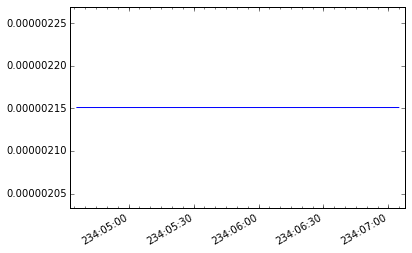

In [146]:
# This are in onboard tracking catalog order not slot order, so fids end up last
pcad_data['AORESY7'].plot()

In [147]:
# The index 6 Z axis data appears in the pcad14eng data instead of the pcad7eng data and is sampled less often.
# This is unlikely to be important for low-number-of-Kalman stars cases, as generally a fid will be in IDX 6 in
# observations that would be a problem.
pcad_data['AORESZ6'].content

'pcad14eng'

In [148]:
pcad_data['AORESZ6'].times[1] - pcad_data['AORESZ6'].times[0]

32.800001859664917

In [149]:
pcad_data['AORESZ7'].times[1] - pcad_data['AORESZ7'].times[0]

4.100000262260437

In [150]:
# For all onboard residual data, I don't see a great way to know if the value is "stale".
# It looks like the fids just don't really update anyway, which makes sense as there is nothing
# to calculate for them.
np.flatnonzero(pcad_data['AORESZ7'].vals[1:] - pcad_data['AORESZ7'].vals[0:-1])

array([], dtype=int64)

## Do the onboard values match expectations?

Do they match independently calculated residuals calculated using using onboard centroids, onboard
quaternions, and known star positions?

In [151]:
q_atts = mica.quaternion.Quat(mica.quaternion.normalize(np.column_stack([pcad_data['AOATTQT1'].vals,
                                        pcad_data['AOATTQT2'].vals,
                                        pcad_data['AOATTQT3'].vals,
                                        pcad_data['AOATTQT4'].vals])))

In [152]:
expected_pos = {}
resids = {}
for entry in catalog[(catalog['type'] == 'BOT') | (catalog['type'] == 'GUI')]:
    slot = entry['slot']
    star = agasc.get_star(entry['id'], date=d.manvr.start)
    eci = radec2eci(star['RA_PMCORR'], star['DEC_PMCORR'])
    d_aca = np.dot(q_atts.transform.transpose(0,2,1), eci)
    yag = np.degrees(np.arctan2(d_aca[:, 1], d_aca[:, 0])) * 3600
    zag = np.degrees(np.arctan2(d_aca[:, 2], d_aca[:, 0])) * 3600
    expected_pos[slot] = {'yag': yag, 'zag': zag}

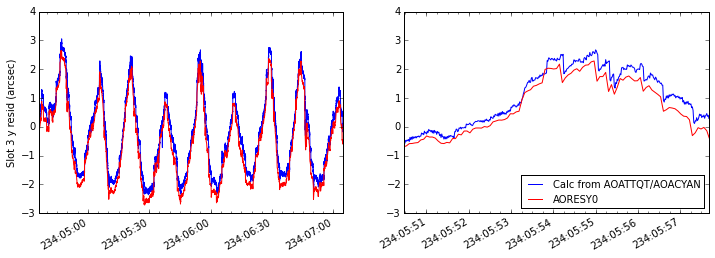

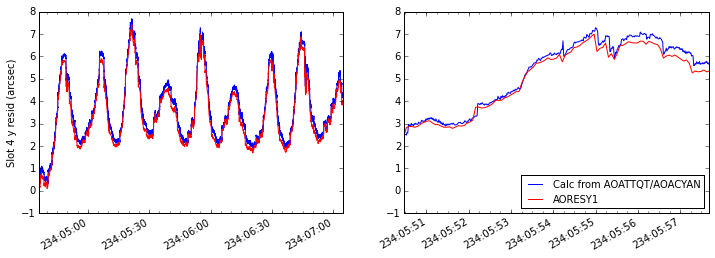

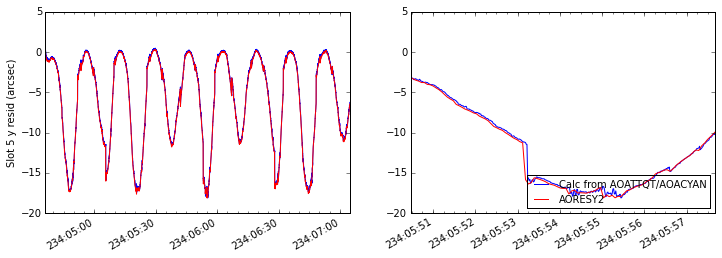

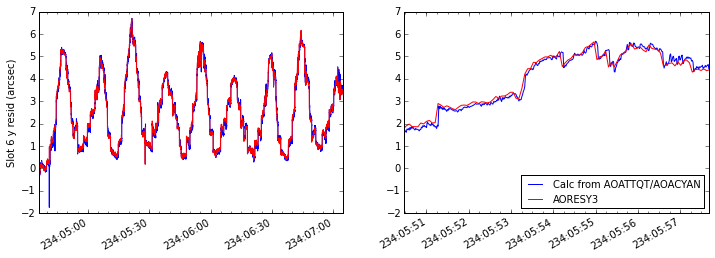

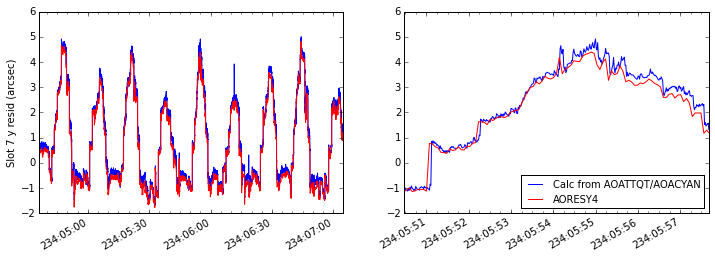

In [153]:
pd = pcad_data
# these slots should work for most ORs
for slot, pos in zip([3, 4, 5, 6, 7],[0, 1, 2, 3, 4]):
    if slot not in expected_pos:
        continue
    fig, axes = subplots(1, 2, figsize=(12, 4))
    aoacyan = pd['AOACYAN{}'.format(slot)]
    ok = pd['AOACFCT{}'.format(slot)].vals == 'TRAK'
    axes[0].set_ylabel("Slot {} y resid (arcsec)".format(slot))
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[0]);
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[0]);
    grid()
    plot_cxctime(aoacyan.times[ok], aoacyan.vals[ok] - expected_pos[slot]['yag'][ok], 'b', ax=axes[1],
                label='Calc from AOATTQT/AOACYAN');
    plot_cxctime(pd['AORESY{}'.format(pos)].times, np.degrees(pd['AORESY{}'.format(pos)].vals) * 3600, 'r', ax=axes[1],
                label='AORESY{}'.format(pos));
    grid()
    legend(loc='lower right', fontsize=10)
    xlims = xlim()
    # zoom in at the midpoint just to look at details of the tracings
    xlim(np.mean(xlims), np.mean(xlims)+.005);


It looks like the onboard residuals anticipate the derived residuals and, of course, may be off by a shift (due to the fact the derived residuals are using star catalog positions and not distances to the other stars), but overall the values seem reasonable. 